In [1]:
import requests, json
from pprint import pprint
from dataclasses import dataclass

session = requests.Session()

termData = {'term': '202310'} # The server needs to know what term you want, this is hardcoded. otherwise, return is empty.
offset = 0 # Offset from the start. max requests is 200, increase by 200
requestSize = 200 # Maximum


session.post('https://ssb9s.capilanou.ca:8443/StudentRegistrationSsb/ssb/term/search?mode=search', data=termData)

requestUrl = f"https://ssb9s.capilanou.ca:8443/StudentRegistrationSsb/ssb/searchResults/searchResults?txt_term={termData['term']}&startDatepicker=&endDatepicker=&pageOffset={offset}&pageMaxSize={requestSize}&sortColumn=subjectDescription&sortDirection=asc"

data=json.loads(session.get(requestUrl).text)['data']
#with open('spring22_200_data', 'r') as f:
#    data = json.loads(f.read())['data']
'''
 Valid classes are those without an empty "meetingsFaculty" and not a "None" building in the meetingTime dictionary.
 "meetingsFaculty" is an array. some classes are both online and in person. or have lab/lecture



 For graphing the schedule for one day of the week, we need the room numbers and begin, end times.

 For the class of dow. It needs to have the roomname, begintime, endtime.
'''
@dataclass
class Monday:
    roomname:str
    begintime: int
    endtime: int
    # test
    index: int
    # test

    @classmethod
    def room(cls, data, num):
        roomname = data['buildingDescription'] + data['room']
        begintime = data['beginTime']
        endtime = data['endTime']
        #test
        index = num
        #test

        return Monday(roomname, begintime, endtime, index)

def roomSearch(data):
    c = 0
    monday = []
    roomList = set() # unique room Names. we can tolerate some inaccuracies.
    for i in data:
    #    print(c)
        if (len(i['meetingsFaculty']) != 0) and (len([e for e in [d for d in i['meetingsFaculty']]]) != 0):
            for f in i['meetingsFaculty']:
                if (f['meetingTime']['building'] != None) and (f['meetingTime']['building'] != "ON") :
                    section = f['meetingTime']
                    roomname = (section['buildingDescription'] + section['room'])
                    #print(roomname)
                    if section['monday'] == True:
                        #monday.append(Monday.room(section, c))
                        roomList.add(roomname)
                        
    
    
    
        c += 1
    #print(monday)
    #return monday
    return list(roomList)

def hourFind(rooms, data):
    c = 0
    roomNHours = {}
    
    for room in rooms:
        roomNHours[room] = [] # initiate the empty list to be filled with tuples
        
    for i in data:
    #    print(c)
        for room in rooms:
            if (len(i['meetingsFaculty']) != 0) and (len([e for e in [d for d in i['meetingsFaculty']]]) != 0):
                for f in i['meetingsFaculty']:
                    if (f['meetingTime']['building'] != None) and (f['meetingTime']['building'] != "ON") :
                        section = f['meetingTime']
                        roomname = (section['buildingDescription'] + section['room'])
                        #print(roomname)
                        if (section['buildingDescription'] + section['room']) == room:
                            #monday.append(Monday.room(section, c))
                            beginTime = int( section["beginTime"][:2] ) + (int( section["beginTime"][-2:] ) * 100 / 60) / 100
                            endTime = int( section["endTime"][:2] ) + (int( section["endTime"][-2:] ) * 100 / 60) / 100
                            roomNHours[room].append( (beginTime, endTime) )
                        
    
    
    
        c += 1
    #print(monday)
    #return monday
    return roomNHours

#roomData = roomSearch(data)
for i in range(1):
    requestUrl = f"https://ssb9s.capilanou.ca:8443/StudentRegistrationSsb/ssb/searchResults/searchResults?txt_term={termData['term']}&startDatepicker=&endDatepicker=&pageOffset={offset}&pageMaxSize={requestSize}&sortColumn=subjectDescription&sortDirection=asc"
    data = json.loads(session.get(requestUrl).text)['data']
    hours = hourFind( roomSearch( data ), data )
    pprint(hours)
    offset += 200

{'Arbutus001': [(10.5, 12.333333333333334),
                (9.5, 11.333333333333334),
                (13.5, 15.333333333333334),
                (13.5, 15.333333333333334),
                (15.5, 17.333333333333332),
                (15.0, 16.833333333333332)],
 'Arbutus117': [(13.5, 15.333333333333334),
                (13.0, 14.833333333333334),
                (15.5, 17.333333333333332),
                (15.5, 17.333333333333332),
                (10.5, 12.333333333333334),
                (10.5, 12.333333333333334),
                (10.5, 12.333333333333334)],
 'Arbutus209': [(9.5, 13.333333333333334),
                (10.0, 13.833333333333334),
                (10.0, 13.833333333333334),
                (11.0, 12.833333333333334),
                (13.5, 15.333333333333334)],
 'Arbutus304': [(14.5, 17.333333333333332),
                (11.5, 14.333333333333334),
                (11.5, 14.333333333333334)],
 'Arbutus315': [(13.0, 14.333333333333334),
                (8.5, 9.833333

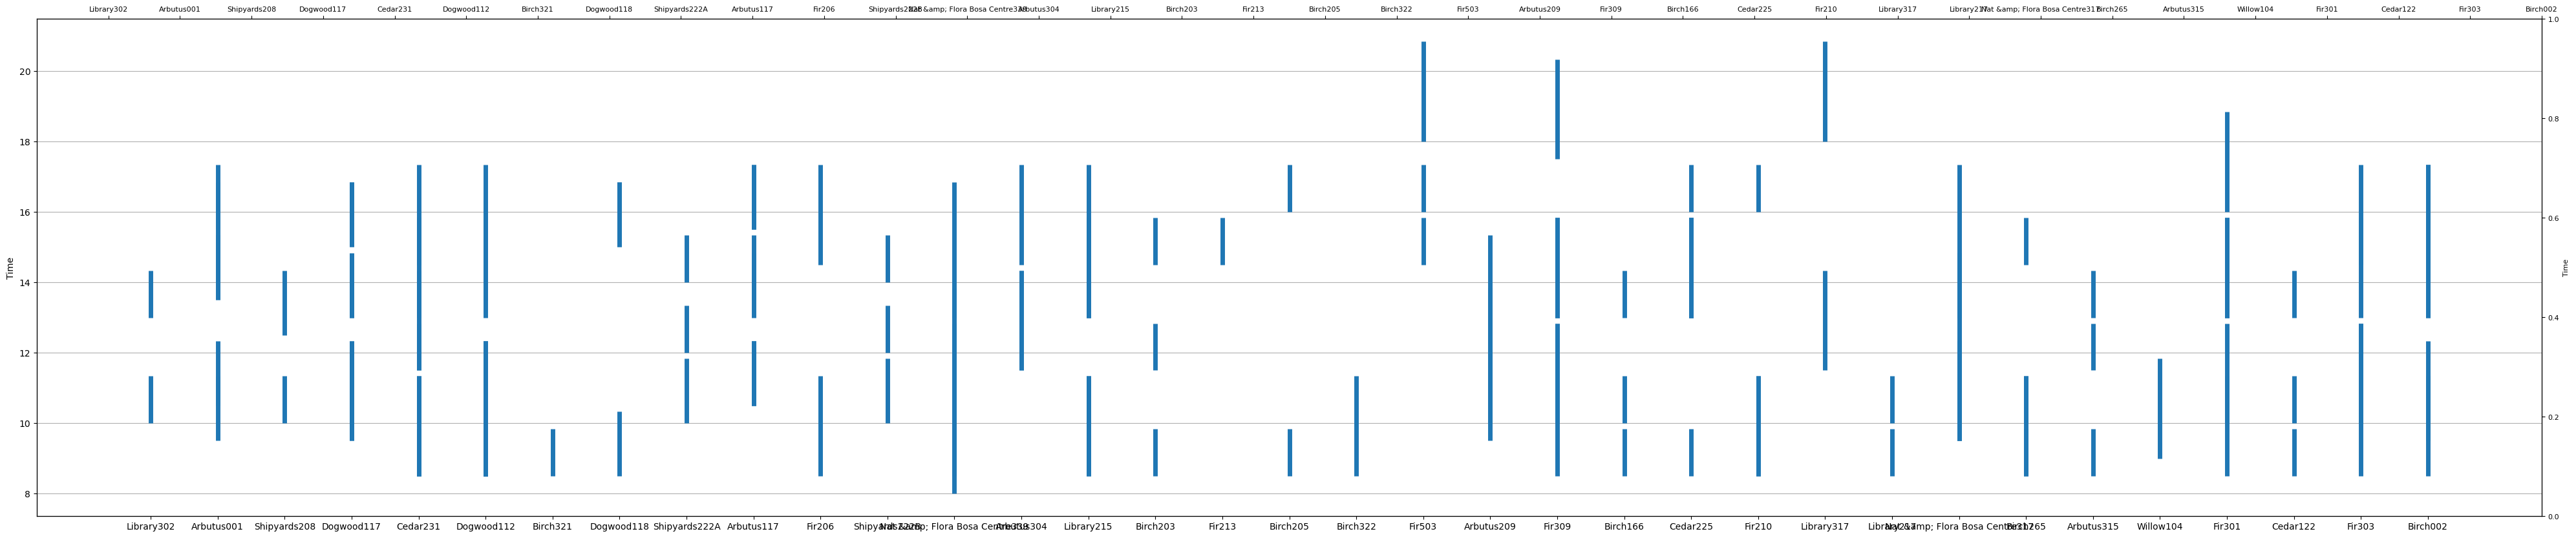

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(50, 10))

plt.rc('font', size=8)

ax.yaxis.grid()

ax.set_xticks( [i for i in range(1, len(hours)+1 )] )
ax.set_xticklabels( list(hours.keys()) )
ax.set_ylabel('Time')

'''
***************************************************************************************/
*    Title: Generate timetable using matplotlib
*    Author: Koji Masuda
*    Date: 2015
*    Availability: https://masudakoji.github.io/2015/05/23/generate-timetable-using-matplotlib/en/
*
***************************************************************************************/
'''
ax2=ax.twiny().twinx()
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels( list(hours.keys()) )
ax2.set_ylabel('Time')
'''
End of citation
'''

pos = 1
for h in hours:
    for t in hours[h]:
        ax.vlines( pos, t[0], t[1], linewidth=5)
    pos += 1
plt.savefig("First 200 results test plot 26 feb.pdf")

